# Custom Data Tutorial

**You are invited to rerun this notebook using your own data!**
Code lines which have to be modified to meet your custom data are postfixed with "# customize to use case".

In this tutorial, we show a **minimal example of training and automated gating to a custom use case**.
It can be divided into three steps:
1. Manual gating of few samples (+ export to .CSV)
2. Train GateNet with exported gating
3. Fully automated gating of new samples with trained GateNet

In this tutorial, manual gating is done with the very basic tool [FlowCytometryTools](https://github.com/eyurtsev/FlowCytometryTools) because it runs in Jupyter and the gates can be easily exported.
More sophisticated tools like FlowJo, Kaluza etc. can also be used. Here exporting the manual gates to the required format would take some extra steps.


## 1. Manual Gating

In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys; sys.path.append('..')
from IPython.display import display
from fastai.basics import pd, plt, glob, torch, Path
from fastai.vision.all import get_grid
from FlowCytometryTools import FCMeasurement, PolyGate

### Explore dataset

Create [pandas Series](https://pandas.pydata.org/docs/reference/api/pandas.Series.html) containing all FCS-filepaths ('fpaths') which should be gated.

**In custom use case:** Move all desired FCS-files ('.fcs' and '.lmd' are supported) into an empty folder and change 'path' to respective folderpath.

In [2]:
path = '/mnt/data-ssd/cyto/tutorial/fcs'  # customize to use case
fpaths = pd.Series(sorted(glob.glob(f'{path}/*')))

The x- and y-axis ('panel') of the scatter plot in which the manual gating should be done are specified.
Subsequently, the samples are loaded into FlowCytometryTools for plotting and manual gating.

**In custom use case:** Change 'panel' to x- and y-axis of the scatter plot in which the manual gating should be done.

In [3]:
panel = ['CD45-KrOrange', 'FSC']  # customize to use case
samples = [FCMeasurement(ID=f'{i}', datafile=f) for i, f in enumerate(fpaths)]
samples = [s.transform(lambda x: x, channels=panel) for s in samples]

Plotting 2d scatter of all samples (in 'panel'-axes)

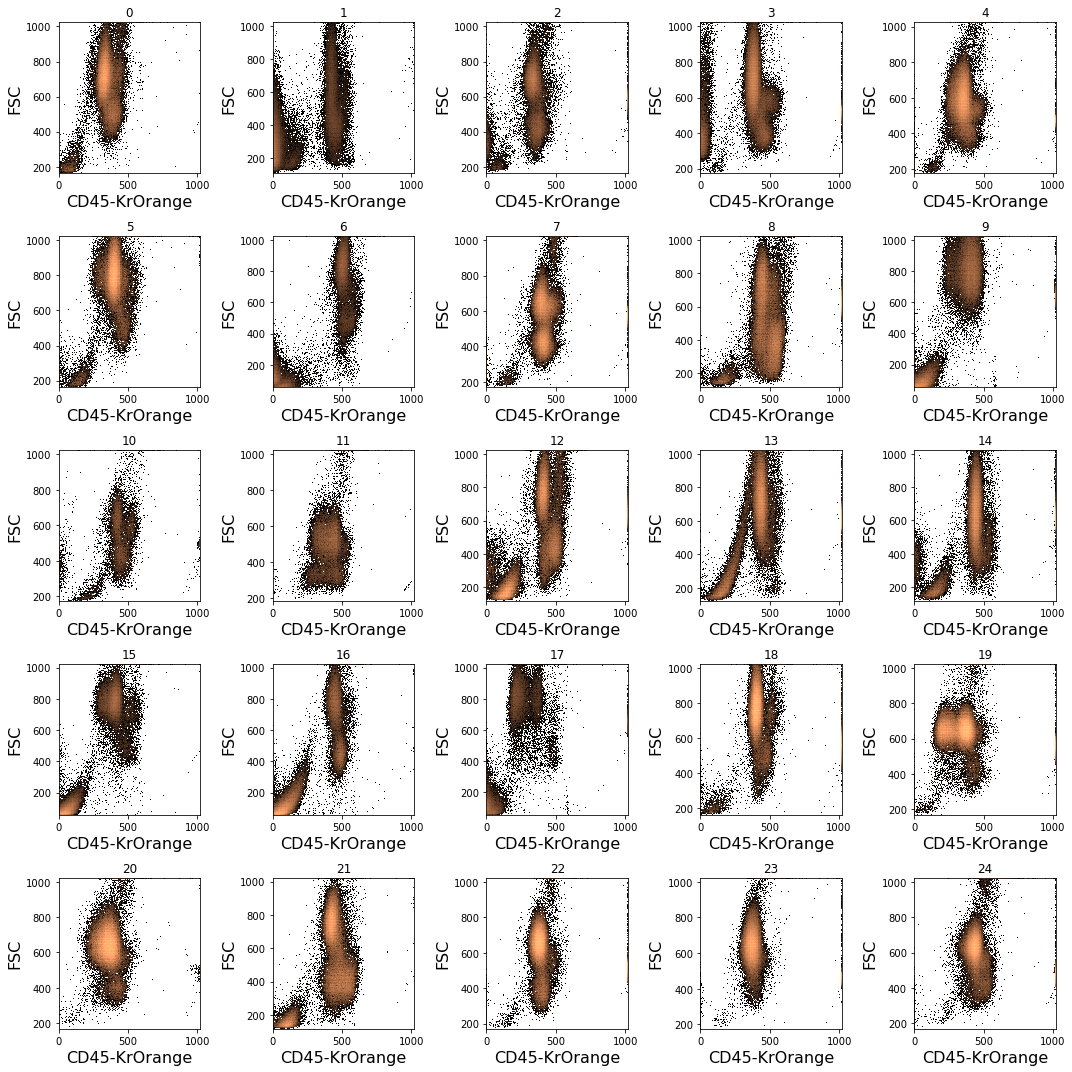

In [4]:
axs = get_grid(len(samples))
for sample, ax in zip(samples, axs):
    sample.plot(panel, ax=ax)
    ax.set_title(sample.ID)
plt.tight_layout()
plt.show()

### Pick training samples

In this example, we would like to gate the **leukocytes** which is the **population in the middle** of each plot. The remaining 'rest' events (primarily bottom left) should NOT be in the gate.

**GateNet can learn with very few training examples** (we will only use 5).

To optimize results **you should pick training samples which**
- you can gate easily (minimal population overlap in 2d scatter)
- show low cell class imbalance (here samples with many 'rest' events)
- show varying batch effects (populations occur in different positions in the scatter across samples)

Based on these criteria we pick 5 training samples which we will gate manually: 2, 3, 9, 14, 16


**In custom use case:** Pick your samples based on criteria above and choose gate name.

In [5]:
gate_name = 'leuko'  # customize to use case
train_idxs = [2, 3, 9, 14, 16]  # customize to use case
train_samples = [s for i, s in enumerate(samples) if i in train_idxs]

### Manual Gating

The following cell opens a widget in which one could **draw a polygon gate** and generate the respective gate polygon-coordinates for each of the train samples.

**In custom use case: Copy & paste the polygon-coordinates** into the "List of polygon-coordinates" cell below!

In [ ]:
for sample in train_samples:
    sample.view_interactively(backend='wx')

#### List of polygon-coordinates
**In custom use case: Copy & paste the polygon-coordinates** of each samples manual gate into the 'polygons'-list. Careful! It is a list of list as each polygon is a list (with 4-5 tuples here). 

In [6]:
polygons = [[(2.574e+02, 1.636e+02), (1.140e+02, 6.332e+02), (1.666e+02, 1.037e+03), (8.179e+02, 1.034e+03), (7.292e+02, 1.790e+02), (2.574e+02, 1.623e+02)],  # customize to use case
            [(2.180e+02, 1.042e+03), (2.015e+02, 4.243e+02), (3.763e+02, 1.772e+02), (8.635e+02, 1.786e+02), (8.025e+02, 1.049e+03), (2.170e+02, 1.042e+03)],  # customize to use case
            [(1.220e+02, 1.053e+03), (9.183e+01, 5.735e+02), (4.121e+02, 4.913e+01), (8.551e+02, 4.617e+01), (7.948e+02, 1.045e+03), (1.261e+02, 1.053e+03)],  # customize to use case
            [(3.424e+02, 1.245e+02), (2.968e+02, 1.039e+03), (7.386e+02, 1.037e+03), (6.619e+02, 1.108e+02), (3.444e+02, 1.232e+02)],  # customize to use case
            [(3.745e+02, 4.173e+01), (2.900e+02, 1.046e+03), (8.821e+02, 1.046e+03), (8.278e+02, 5.397e+01), (3.745e+02, 4.326e+01)]]  # customize to use case
gates = [PolyGate(p, panel, region='in', name=gate_name) for p in polygons]

### Export gates as .CSV-files
The manual gates are saved as **.CSV-files in which the cell type of each individual event** is given (in a [one-hot encoded format](https://www.kaggle.com/code/dansbecker/using-categorical-data-with-one-hot-encoding/notebook)).

**In custom use case:** Specify empty folder in which manual gates will be saved and change 'train_gates_path' to respective folderpath.

In [7]:
train_gates_path = '/mnt/data-ssd/cyto/tutorial/gates_manual'  # customize to use case
gate_fnames = fpaths.apply(lambda x: Path(x).stem + '.csv')

for i, g in zip(train_idxs, gates):
    sample_index = samples[i].get_data().index
    gate_index = samples[i].gate(g).get_data().index
    
    gate = pd.DataFrame(0, columns=['leuko'], index=sample_index)
    gate.loc[sample_index.isin(gate_index)] = 1
    
    gate.to_csv(f'{train_gates_path}/{gate_fnames[i]}', index=False)
    print(f'Gating exported to {train_gates_path}/{gate_fnames[i]}')

Gating exported to /mnt/data-ssd/cyto/tutorial/gates_manual/02.csv
Gating exported to /mnt/data-ssd/cyto/tutorial/gates_manual/03.csv
Gating exported to /mnt/data-ssd/cyto/tutorial/gates_manual/09.csv
Gating exported to /mnt/data-ssd/cyto/tutorial/gates_manual/14.csv
Gating exported to /mnt/data-ssd/cyto/tutorial/gates_manual/16.csv


## 2. Train GateNet

### Prepare training
To train a custom GateNet 4 things are needed:
1. [pandas Dataframe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) containing all training filepaths (here 'df_train'). FCS-filepaths in 'fcs'-column and gating-filepaths in 'labels'-column
2. Dictionary with GatingDataset keyword arguments (here 'ds_kwargs'). See data/set.py for all possible kwargs
3. Dictionary with GateNetLoader keyword arguments (here 'dl_kwargs'). See data/loader.py for all possible kwargs
4. Dictionary with training hyperparameters (here 'hparams'). See train.py for all possible kwargs

In [8]:
from src.train import HPARAMS, train
from src.data.utils import get_norm_stats
from src.utils import set_seed

# Fix seed for deterministic results
set_seed(seed=0)

df = pd.DataFrame({'fcs': fpaths, 'labels': train_gates_path + '/' + gate_fnames})
df_train = df.loc[train_idxs]
display(df_train)

# 'vocab' defines which cells (i.e. columns in the exported gating .CSVs) should be gated
# if 'vocab' contains 'rest', a rest class will be inferred
ds_kwargs = {'vocab': [gate_name, 'rest']}
# 'fcs_norm_stats' is a dict containing the mean and standard deviation of the fcs-markers ('fcs', 'ssc', 'cd4'...)
dl_kwargs = {'fcs_norm_stats': get_norm_stats(df_train.fcs)}

# Training hyperparameters ('HPARAMS' contains default parameters from the paper)
hparams = HPARAMS
# Reducing 'iters' (default 5000) for quicker test runs (but slightly lower performance)
hparams.update({'iters': 1000, 'n_context_events': 100})

,fcs,labels
2,/mnt/data-ssd/cyto/tutorial/fcs/02.LMD,/mnt/data-ssd/cyto/tutorial/gates_manual/02.csv
3,/mnt/data-ssd/cyto/tutorial/fcs/03.LMD,/mnt/data-ssd/cyto/tutorial/gates_manual/03.csv
9,/mnt/data-ssd/cyto/tutorial/fcs/09.LMD,/mnt/data-ssd/cyto/tutorial/gates_manual/09.csv
14,/mnt/data-ssd/cyto/tutorial/fcs/14.LMD,/mnt/data-ssd/cyto/tutorial/gates_manual/14.csv
16,/mnt/data-ssd/cyto/tutorial/fcs/16.LMD,/mnt/data-ssd/cyto/tutorial/gates_manual/16.csv


### Model training
GateNet gets trained with the training files 'df_train' and the settings specified in 'hparams', 'ds_kwargs' and 'dl_kwargs'. 

As we don't have validation files in this example, 'df_valid' is set to None.

In [9]:
learner = train(df_train, df_valid=None, hparams=hparams, ds_kwargs=ds_kwargs, dl_kwargs=dl_kwargs)

Save trained GateNet model as .pt-file (here named "gatenet.pt")

In [10]:
torch.save(learner.model.state_dict(), model_path := 'gatenet.pt')

## 3. Fully automated gating

To predict (i.e. gate automatically) with a custom GateNet we need 5 things:
1. Filepath of the trained GateNet model (here 'model_path')
2. [pandas Dataframe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) containing all FCS-filepaths in a 'fcs'-column (here 'df_predict').
3. Dictionary with training hyperparameters (here 'hparams')
4. Dictionary with GatingDataset keyword arguments (here 'ds_kwargs')
5. Dictionary with GateNetLoader keyword arguments (here 'dl_kwargs')

**In custom use case:** Specify folder in which automatic gates will be saved and change 'auto_gates_path' to respective folderpath.

In [11]:
from src.predict import predict

df_predict = df.loc[~df.index.isin(train_idxs), ['fcs']]
#display(df_predict)

result = predict(model_path, df_predict, hparams, ds_kwargs, dl_kwargs, progress_bar=True)
print(f'{len(df_predict)} samples gated successfully ({len(result)} events in total)')

auto_gates_path = '/mnt/data-ssd/cyto/tutorial/gates_auto'  # customize to use case

for fpath, fresult in result.groupby('id'):
    gate = fresult[gate_name].to_frame(gate_name)
    gate_fpath = f'{auto_gates_path}/{Path(fpath).stem}.csv'
    gate.to_csv(gate_fpath, index=False)
    print(f'Automatic gating exported to {gate_fpath}')
    

20 samples gated successfully (2504285 events in total)
Automatic gating exported to /mnt/data-ssd/cyto/tutorial/gates_auto/00.csv
Automatic gating exported to /mnt/data-ssd/cyto/tutorial/gates_auto/01.csv
Automatic gating exported to /mnt/data-ssd/cyto/tutorial/gates_auto/04.csv
Automatic gating exported to /mnt/data-ssd/cyto/tutorial/gates_auto/05.csv
Automatic gating exported to /mnt/data-ssd/cyto/tutorial/gates_auto/06.csv
Automatic gating exported to /mnt/data-ssd/cyto/tutorial/gates_auto/07.csv
Automatic gating exported to /mnt/data-ssd/cyto/tutorial/gates_auto/08.csv
Automatic gating exported to /mnt/data-ssd/cyto/tutorial/gates_auto/10.csv
Automatic gating exported to /mnt/data-ssd/cyto/tutorial/gates_auto/11.csv
Automatic gating exported to /mnt/data-ssd/cyto/tutorial/gates_auto/12.csv
Automatic gating exported to /mnt/data-ssd/cyto/tutorial/gates_auto/13.csv
Automatic gating exported to /mnt/data-ssd/cyto/tutorial/gates_auto/15.csv
Automatic gating exported to /mnt/data-ssd/c

### Visualize results
With 'show_probabilities = True' the predicted probability (float between 0 and 1) of each event being the cell type (here "leuko") is shown. This results in a plot like shown in data/autogates.png. Else, the probabilities are binarized (i.e. < 0.5 = 0, and > 0.5 = 1). 

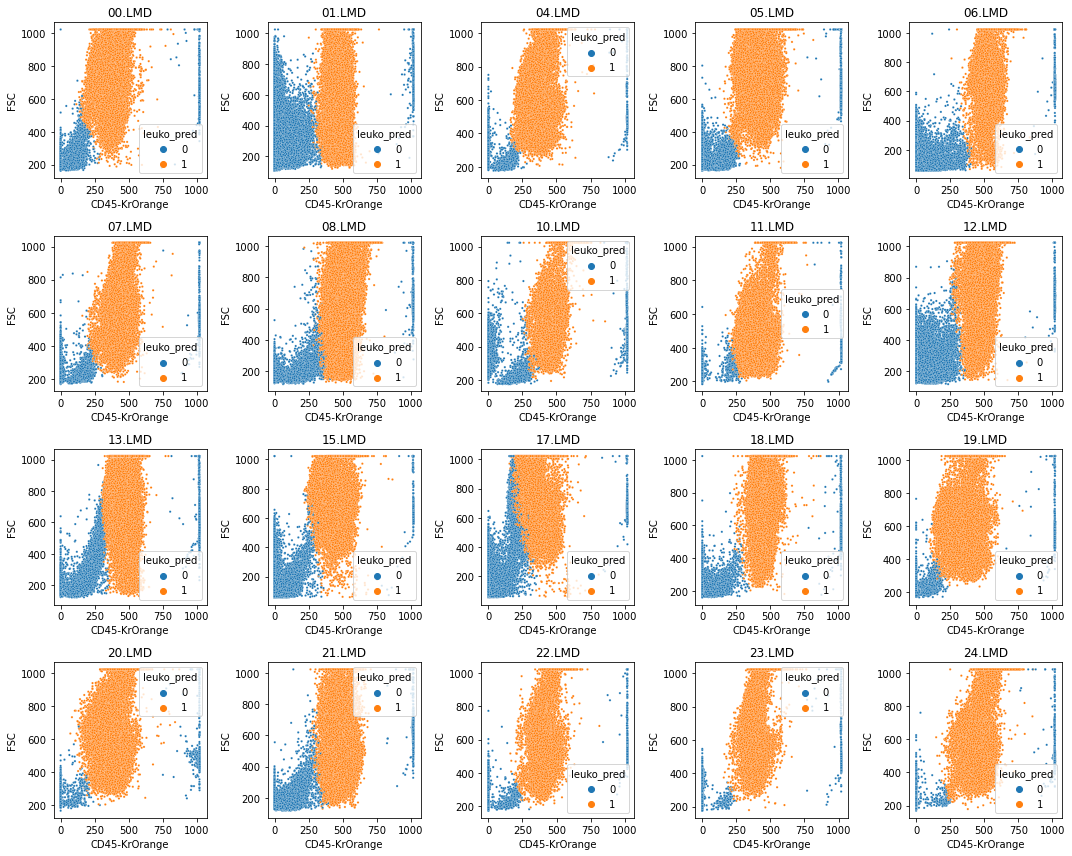

In [13]:
import seaborn as sn

show_probabilities = False

axs = get_grid(len(df_predict))
for i, (fpath, fresult) in enumerate(result.groupby('id')):
    if not show_probabilities:
        fresult[f'{gate_name}_pred'] = (fresult[f'{gate_name}_pred'] > .5).astype(int)
    sn.scatterplot(data=fresult, x=panel[0], y=panel[1], hue=f'{gate_name}_pred', s=5, ax=axs[i])
    axs[i].set_title(Path(fpath).name)

plt.tight_layout()
plt.show()